In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



[cuda(id=0)]
gpu
[cuda(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [2]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
        Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)





R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [3]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [4]:
len(valid_batches)

6621

In [42]:
N = 30
random_ids = [random.randint(0, len(valid_batches)) for _ in range(N)]

In [66]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")
# p = ddir / "runs10/20240923-175645dcm-4-espw-10000.0-restart-False/best_10000.0_params.pkl"


# p = ddir / "runs11/20240924-142048dcm-2-espw-1000.0-restart-False/best_1000.0_params.pkl"
p = ddir / "runs11/20240924-141337dcm-2-espw-1000.0-restart-False/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-141632dcm-2-espw-1000.0-restart-False/best_1000.0_params.pkl"

# p = ddir / "runs11/20240924-142115dcm-3-espw-1000.0-restart-False/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-141426dcm-3-espw-1000.0-restart-False/best_1000.0_params.pkl"

# p = ddir / "runs11/20240924-142048dcm-4-espw-1000.0-restart-False/best_1000.0_params.pkl"
# p = ddir / "runs11/20240924-144050dcm-4-espw-1000.0-restart-False/best_1000.0_params.pkl"

model, params = create_model_and_params(p)
model

{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0, 'include_pseudotensors': True}


MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
    include_pseudotensors = True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.39s/it]


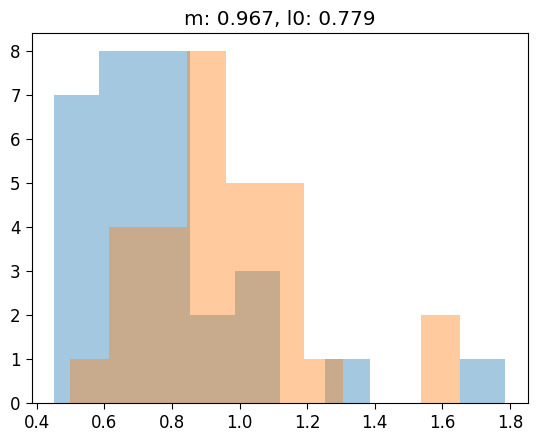

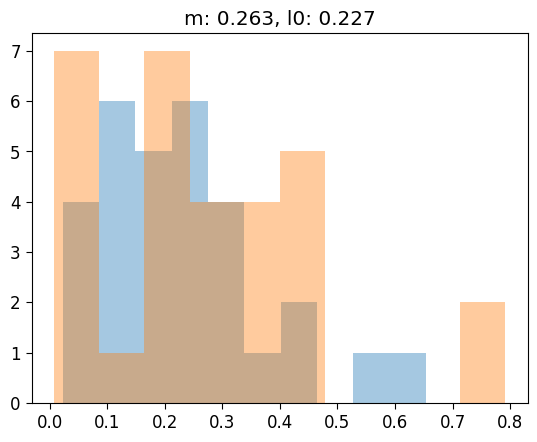

In [67]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(random_ids):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=False,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [68]:
df_ = pd.DataFrame({"i": indexes, "m": m.flatten(), "l0": l0.flatten(), "dm": dm, "dl0": dl0})
df_["dif"] = df_["m"] - df_["l0"]
df_["difd"] = df_["dm"] - df_["dl0"]
df_.describe()

,i,m,l0,dm,dl0,dif,difd
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3472.000000,0.966653,0.779273,0.263210,0.227267,0.187379,0.035943
std,1849.176145,0.246957,0.280304,0.187512,0.151111,0.218713,0.219897
min,469.000000,0.499802,0.452227,0.007500,0.022202,-0.241255,-0.472958
25%,1963.500000,0.810002,0.604313,0.137344,0.118825,0.045409,-0.062797
50%,3813.000000,0.927006,0.728245,0.243147,0.204608,0.179608,0.065346
75%,5241.750000,1.102761,0.833750,0.350975,0.282406,0.318561,0.172198
max,6437.000000,1.651020,1.785673,0.791620,0.653875,0.715511,0.567893


In [69]:
good = list(df_[df_["dif"] < 0 ].sort_values("dif", ascending=True)["i"])
print(len(good))
df_[df_["dif"] < 0].sort_values("dif", ascending=True)

5


,i,m,l0,dm,dl0,dif,difd
9,469,1.139000,1.380256,0.081736,0.554694,-0.241255,-0.472958
14,3881,0.499802,0.697932,0.190301,0.022202,-0.198129,0.168099
7,4238,1.651020,1.785673,0.442010,0.415510,-0.134653,0.026501
12,2516,0.744192,0.835103,0.345537,0.265474,-0.090911,0.080063
1,4906,1.034078,1.107217,0.281911,0.192270,-0.073140,0.089641


  0%|                                                                                                        | 0/2 [00:00<?, ?it/s]

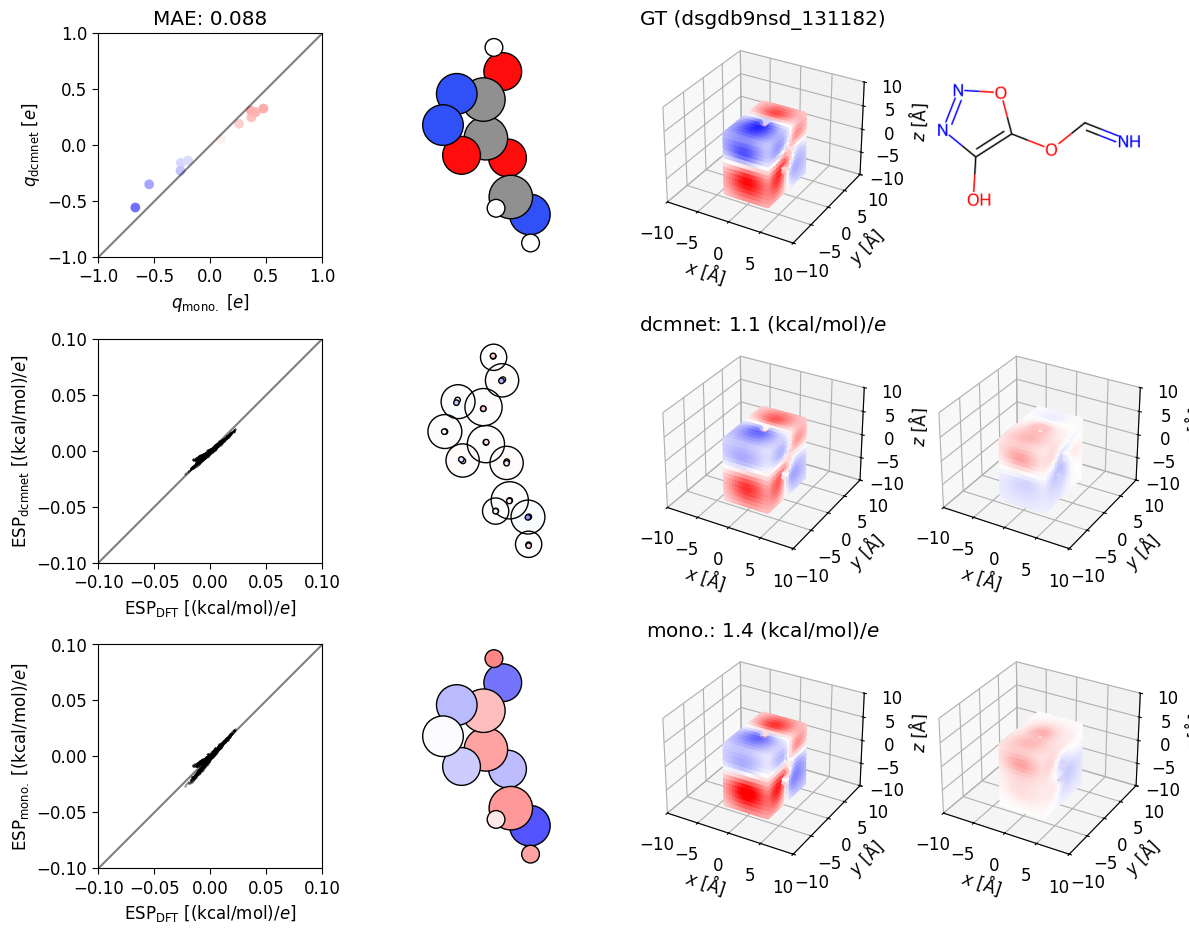

 50%|████████████████████████████████████████████████                                                | 1/2 [00:07<00:07,  7.41s/it]

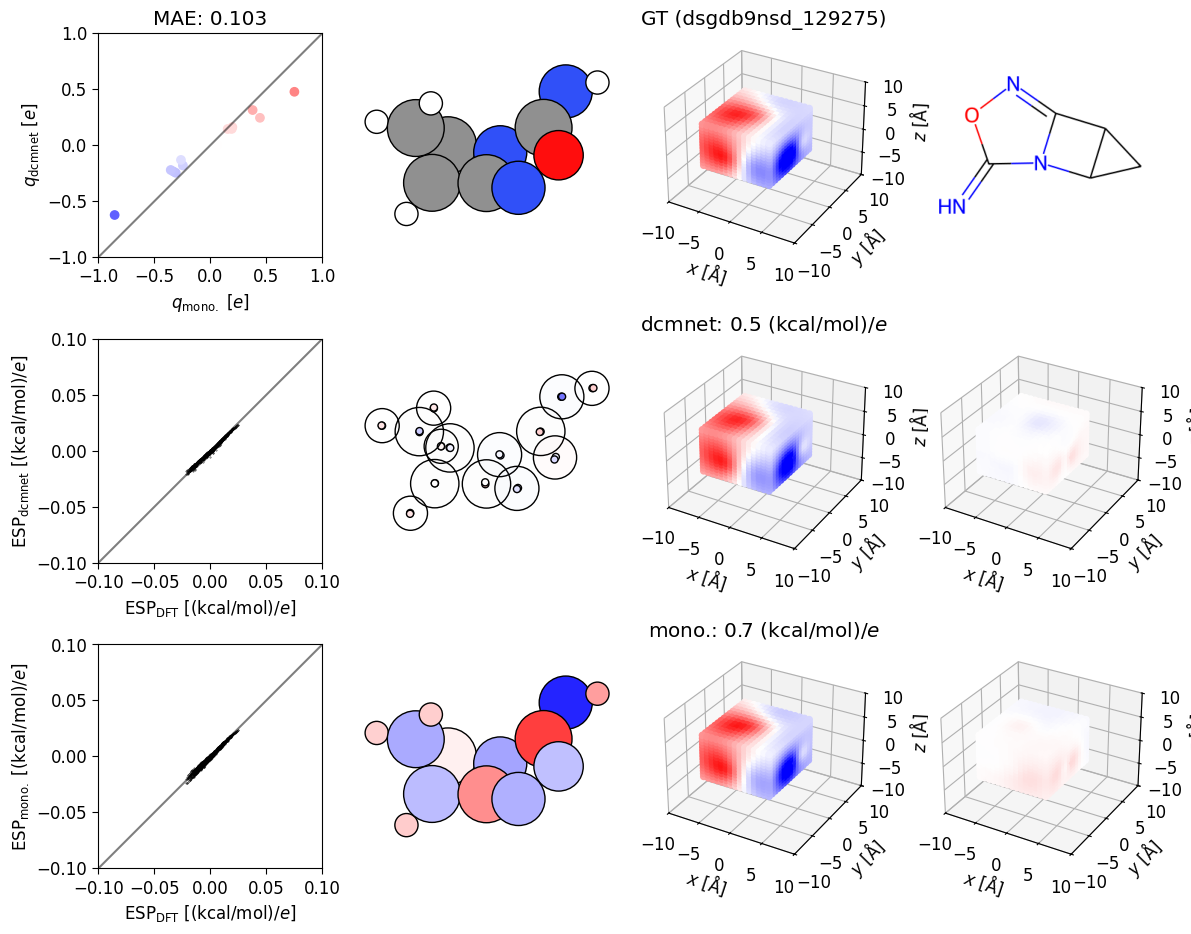

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.71s/it]


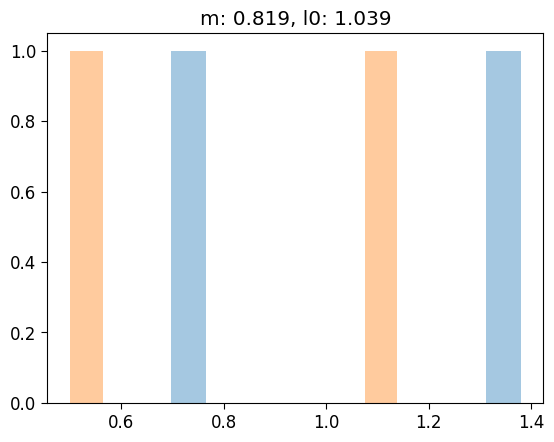

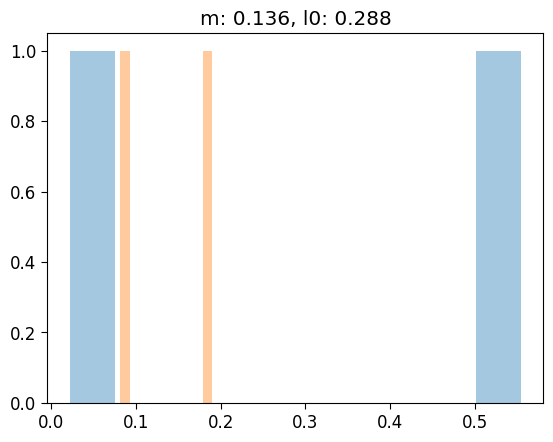

In [70]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(good[:2]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [71]:

bad = list(df_[df_["dif"] > .1].sort_values("dif", ascending=False)["i"])
len(bad)


21

  0%|                                                                                                        | 0/2 [00:00<?, ?it/s]

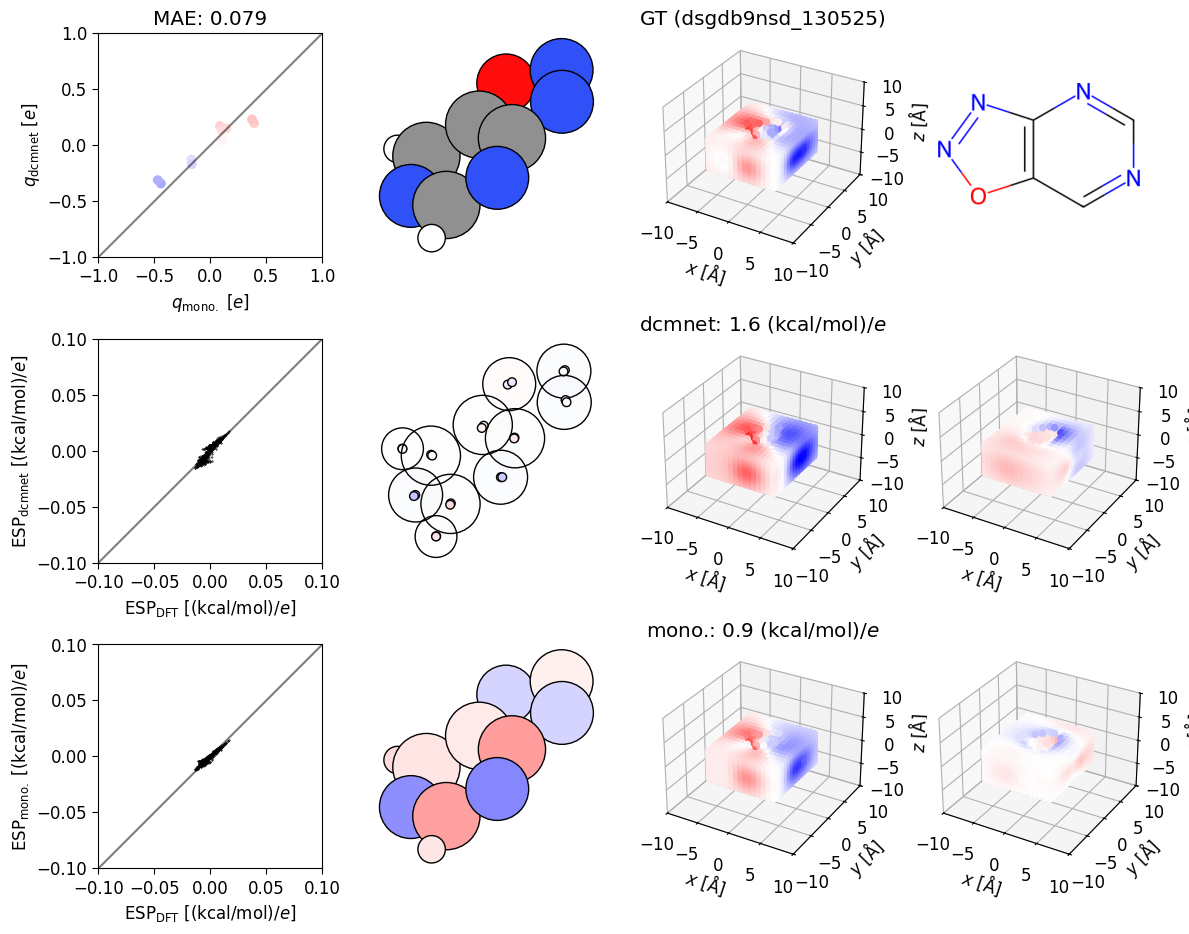

 50%|████████████████████████████████████████████████                                                | 1/2 [00:07<00:07,  7.66s/it]

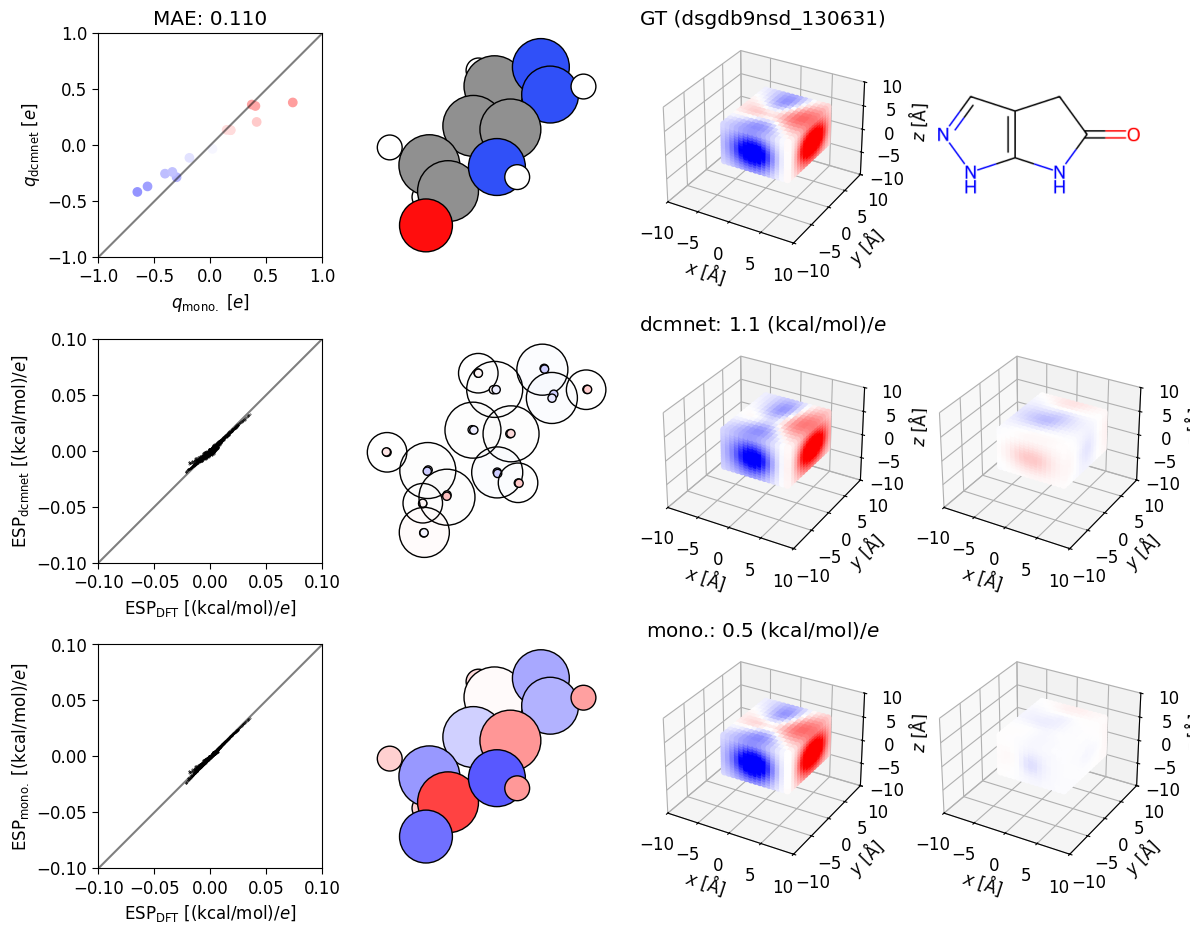

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.70s/it]


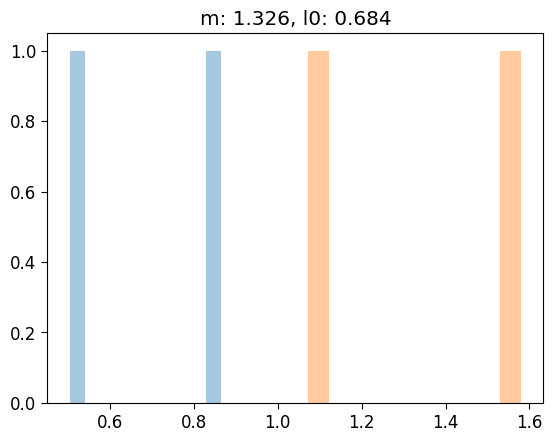

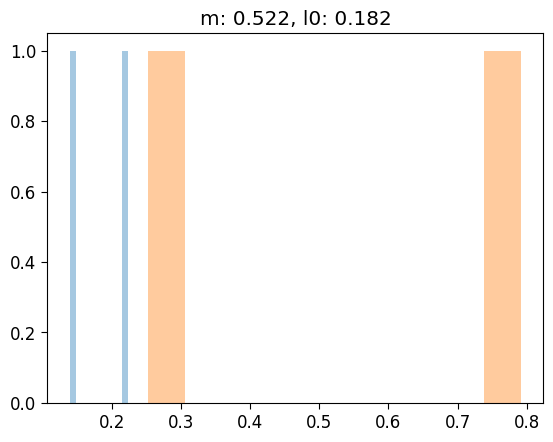

In [72]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(bad[:2]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()